In [28]:
from pyspark import SparkConf, SparkContext
import collections

conf = SparkConf().setMaster('local').setAppName('AutoLinearRegression')
sc = SparkContext(conf = conf)

autoData = sc.textFile("auto-miles-per-gallon.csv")
autoData.cache()
autoData.take(5)

['MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,NAME',
 '18,8,307,130,3504,12,70,chevrolet chevelle malibu',
 '15,8,350,165,3693,11.5,70,buick skylark 320',
 '18,8,318,150,3436,11,70,plymouth satellite',
 '16,8,304,150,3433,12,70,amc rebel sst']

In [29]:
from pyspark import SparkConf, SparkContext
import collections

conf = SparkConf().setMaster('local').setAppName('AutoLinearRegression')
sc = SparkContext(conf = conf)

autoData = sc.textFile("auto-miles-per-gallon.csv")
autoData.cache()
autoData.take(5)

398

In [30]:
dataLines.take(2)

['18,8,307,130,3504,12,70,chevrolet chevelle malibu',
 '15,8,350,165,3693,11.5,70,buick skylark 320']

In [31]:
from pyspark.sql import Row

#Use default for average HP
avgHP =sc.broadcast(80.0)

#Function to cleanup Data
def CleanupData( inputStr) :
    global avgHP
    attList=inputStr.split(",")
    
    #Replace ? values with a normal value
    hpValue = attList[3]
    if hpValue == "?":
        hpValue=avgHP.value
       
    #Create a row with cleaned up and converted data
    values= Row(     MPG=float(attList[0]),\
                     CYLINDERS=float(attList[1]), \
                     DISPLACEMENT=float(attList[2]), 
                     HORSEPOWER=float(hpValue),\
                     WEIGHT=float(attList[4]), \
                     ACCELERATION=float(attList[5]), \
                     MODELYEAR=float(attList[6]),\
                     NAME=attList[7]  ) 
    return values
#Run map for cleanup
autoMap = dataLines.map(CleanupData)
autoMap.cache()
autoMap.take(5)

[Row(ACCELERATION=12.0, CYLINDERS=8.0, DISPLACEMENT=307.0, HORSEPOWER=130.0, MODELYEAR=70.0, MPG=18.0, NAME='chevrolet chevelle malibu', WEIGHT=3504.0),
 Row(ACCELERATION=11.5, CYLINDERS=8.0, DISPLACEMENT=350.0, HORSEPOWER=165.0, MODELYEAR=70.0, MPG=15.0, NAME='buick skylark 320', WEIGHT=3693.0),
 Row(ACCELERATION=11.0, CYLINDERS=8.0, DISPLACEMENT=318.0, HORSEPOWER=150.0, MODELYEAR=70.0, MPG=18.0, NAME='plymouth satellite', WEIGHT=3436.0),
 Row(ACCELERATION=12.0, CYLINDERS=8.0, DISPLACEMENT=304.0, HORSEPOWER=150.0, MODELYEAR=70.0, MPG=16.0, NAME='amc rebel sst', WEIGHT=3433.0),
 Row(ACCELERATION=10.5, CYLINDERS=8.0, DISPLACEMENT=302.0, HORSEPOWER=140.0, MODELYEAR=70.0, MPG=17.0, NAME='ford torino', WEIGHT=3449.0)]

In [32]:
from pyspark.sql.session import SparkSession
spark = SparkSession(sc)
autoDf = spark.createDataFrame(autoMap)

In [33]:
autoDf.show()

+------------+---------+------------+----------+---------+----+--------------------+------+
|ACCELERATION|CYLINDERS|DISPLACEMENT|HORSEPOWER|MODELYEAR| MPG|                NAME|WEIGHT|
+------------+---------+------------+----------+---------+----+--------------------+------+
|        12.0|      8.0|       307.0|     130.0|     70.0|18.0|chevrolet chevell...|3504.0|
|        11.5|      8.0|       350.0|     165.0|     70.0|15.0|   buick skylark 320|3693.0|
|        11.0|      8.0|       318.0|     150.0|     70.0|18.0|  plymouth satellite|3436.0|
|        12.0|      8.0|       304.0|     150.0|     70.0|16.0|       amc rebel sst|3433.0|
|        10.5|      8.0|       302.0|     140.0|     70.0|17.0|         ford torino|3449.0|
|        10.0|      8.0|       429.0|     198.0|     70.0|15.0|    ford galaxie 500|4341.0|
|         9.0|      8.0|       454.0|     220.0|     70.0|14.0|    chevrolet impala|4354.0|
|         8.5|      8.0|       440.0|     215.0|     70.0|14.0|   plymouth fury 

In [34]:
autoDf.select("MPG","CYLINDERS").describe().show()

+-------+------------------+------------------+
|summary|               MPG|         CYLINDERS|
+-------+------------------+------------------+
|  count|               398|               398|
|   mean|23.514572864321615| 5.454773869346734|
| stddev| 7.815984312565783|1.7010042445332123|
|    min|               9.0|               3.0|
|    max|              46.6|               8.0|
+-------+------------------+------------------+



In [35]:
import six
for i in autoDf.columns:
    if not( isinstance(autoDf.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MPG for ", i, autoDf.stat.corr('MPG',i))

Correlation to MPG for  ACCELERATION 0.42028891210165054
Correlation to MPG for  CYLINDERS -0.7753962854205539
Correlation to MPG for  DISPLACEMENT -0.8042028248058979
Correlation to MPG for  HORSEPOWER -0.7746308409203806
Correlation to MPG for  MODELYEAR 0.5792671330833092
Correlation to MPG for  MPG 1.0
Correlation to MPG for  WEIGHT -0.8317409332443344


In [36]:
from pyspark.ml.linalg import Vectors
def transformToLabeledPoint(row) :
    lp = ( row["MPG"], Vectors.dense([row["ACCELERATION"],\
                        row["DISPLACEMENT"], \
                        row['CYLINDERS'], \
                        row['HORSEPOWER'], \
                        row['MODELYEAR'], \
                        row["WEIGHT"]]))
    return lp
    
autoLp = autoMap.map(transformToLabeledPoint)
autoDF = spark.createDataFrame(autoLp,["label", "features"])
autoDF.select("label","features").show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 18.0|[12.0,307.0,8.0,1...|
| 15.0|[11.5,350.0,8.0,1...|
| 18.0|[11.0,318.0,8.0,1...|
| 16.0|[12.0,304.0,8.0,1...|
| 17.0|[10.5,302.0,8.0,1...|
| 15.0|[10.0,429.0,8.0,1...|
| 14.0|[9.0,454.0,8.0,22...|
| 14.0|[8.5,440.0,8.0,21...|
| 14.0|[10.0,455.0,8.0,2...|
| 15.0|[8.5,390.0,8.0,19...|
+-----+--------------------+
only showing top 10 rows



In [37]:
autoLp.take(2)

[(18.0, DenseVector([12.0, 307.0, 8.0, 130.0, 70.0, 3504.0])),
 (15.0, DenseVector([11.5, 350.0, 8.0, 165.0, 70.0, 3693.0]))]

In [38]:
#Split into training and testing data
(trainingData, testData) = autoDF.randomSplit([0.9, 0.1])
trainingData.count()

353

In [39]:
testData.count()

45

In [40]:
#Build the model on training data
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(maxIter=10)
lrModel = lr.fit(trainingData)

#Print the metrics
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.16427367587386635,0.005728119464731595,0.03359233550214317,0.006591474875028307,0.7930623355395598,-0.007536178476476788]
Intercept: -18.847473453514816


In [41]:
#Predict on the test data
predictions = lrModel.transform(testData)
predictions.select("prediction","label","features").show()

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|5.6564092079153525| 12.0|[11.5,383.0,8.0,1...|
| 21.57026725172836| 13.0|[12.0,302.0,8.0,1...|
| 4.408773684229374| 13.0|[12.0,400.0,8.0,1...|
|10.891650769508907| 14.0|[12.0,400.0,8.0,1...|
|12.559495834338364| 14.0|[13.0,351.0,8.0,1...|
|12.576259041267999| 14.0|[14.5,318.0,8.0,1...|
|15.044187617469802| 14.5|[12.8,351.0,8.0,1...|
|  15.0413820490704| 15.0|[10.0,383.0,8.0,1...|
| 9.626289986249908| 15.0|[10.0,429.0,8.0,1...|
|13.648298639807372| 15.0|[13.0,350.0,8.0,1...|
|15.440860014095513| 15.5|[12.2,400.0,8.0,1...|
|16.651393004636382| 15.5|[13.9,304.0,8.0,1...|
|15.192399360192631| 16.0|[14.5,351.0,8.0,1...|
|21.920447836734972| 16.2|[15.8,163.0,6.0,1...|
|16.689649769494807| 16.9|[14.9,350.0,8.0,1...|
|17.527417050323272| 17.5|[13.7,318.0,8.0,1...|
|20.097088517242398| 18.0|[14.5,121.0,4.0,1...|
| 21.67003545796419| 18.0|[16.0,232.0,6.

In [42]:
#Find R2 for Linear Regression
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
evaluator.evaluate(predictions)

0.6723530653282122

In [44]:
autoDf.dtypes

[('ACCELERATION', 'double'),
 ('CYLINDERS', 'double'),
 ('DISPLACEMENT', 'double'),
 ('HORSEPOWER', 'double'),
 ('MODELYEAR', 'double'),
 ('MPG', 'double'),
 ('NAME', 'string'),
 ('WEIGHT', 'double')]

In [45]:
numeric_features = [t[0] for t in autoDf.dtypes if t[1] == 'int' or t[1] == 'double']

In [46]:
sampled_data = autoDf.select(numeric_features).toPandas()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  app.launch_new_instance()


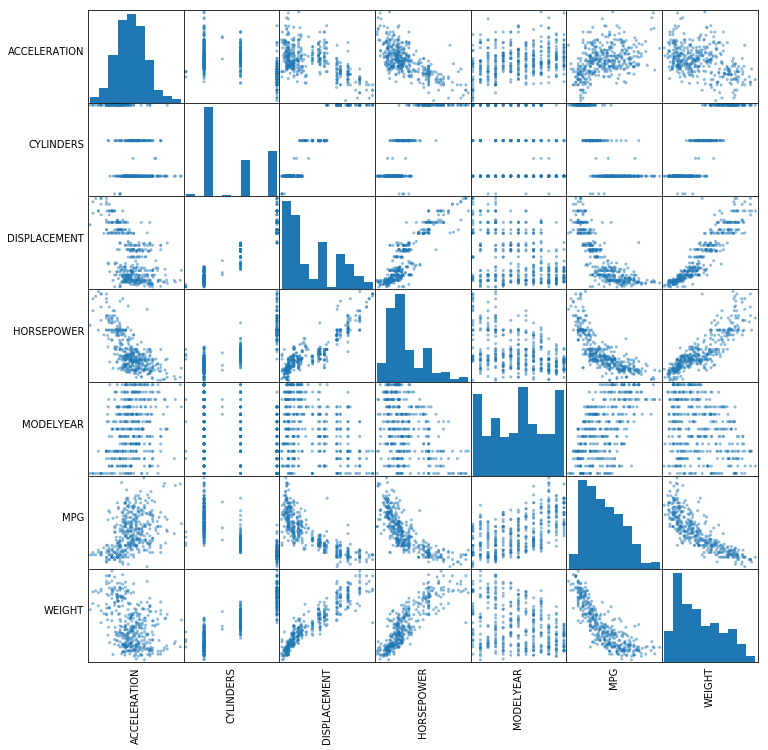

In [49]:
import pandas as pd

axs = pd.scatter_matrix(sampled_data, figsize=(12, 12))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())